In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import process_video
from src.distance_measures import analyse_image, analyse_video
from src.gaussian_noise import generate_noise, generate_noise_array
from src.visualizer import visualize

In [2]:
L=50
size=400
noise_t=0.16369889996315873
noise_a=2.62037301239601

In [3]:
label_video = process_video('images/cheese_gel.avi',
                            threshold=0.3,
                            smooth=1,
                            skip_size=24,
                            size=size)
label_video = label_video[:7]

In [4]:
F_list, G_list = analyse_video(label_video, L=L)

In [5]:
noise_list = generate_noise_array(size, amount=10, threshold=noise_t, smooth=noise_a)
noiseF_list, noiseG_list = analyse_video(noise_list, L=L)

# Taking mean of noisy images
noiseF = np.mean(noiseF_list, axis=0)
noiseG = np.mean(noiseG_list, axis=0)

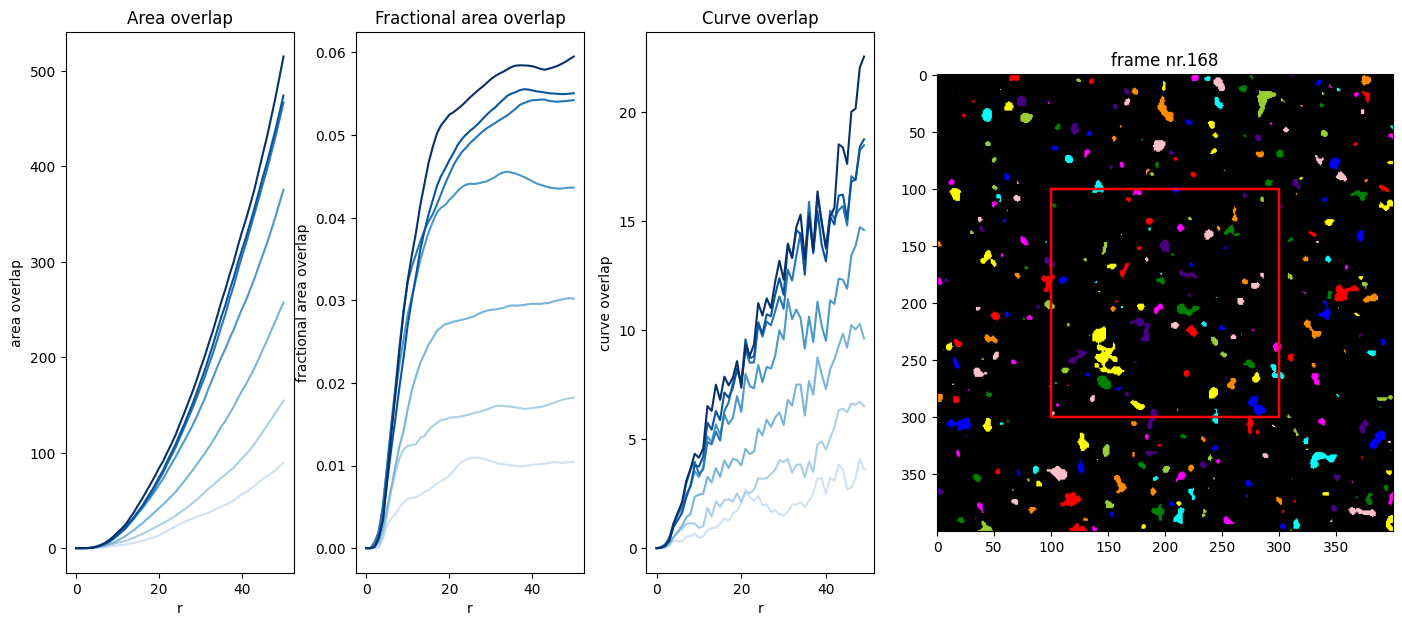

In [9]:
# visualize(label_video, F_list, G_list, noiseF, noiseG)
visualize(label_video, F_list, G_list, save=False)